In [11]:
import numpy as np
import pandas as pd 
import os

In [12]:
import cv2 

## Data preprocessing

#### Data Loading
In this section, three main datasets are loaded:
- df_images: Contains the image data for object detection, including file paths for image_id, image_name, and corresponding metadata.
- df_labels: Contains the ground truth labels for object detection, including object_class, bounding_box_coordinates, and image_id.
- df_calibration: Includes calibration parameters such as camera matrix, distortion coefficients, and extrinsic parameters for aligning image and sensor data.

In [13]:
image_path  = "./data_object_image_2/training/image_2/"

In [14]:
# List all image files
image_files = os.listdir(image_path)

# Create a DataFrame to store image file paths
df_images = pd.DataFrame({
    'image_id': range(len(image_files)),
    'image_name': image_files,
    'file_path': [os.path.join(image_path, img) for img in image_files]
})

In [15]:
# Print the first few entries of df_images
print(df_images.head())

   image_id  image_name                                          file_path
0         0  000000.png  ./data_object_image_2/training/image_2/000000.png
1         1  000001.png  ./data_object_image_2/training/image_2/000001.png
2         2  000002.png  ./data_object_image_2/training/image_2/000002.png
3         3  000003.png  ./data_object_image_2/training/image_2/000003.png
4         4  000004.png  ./data_object_image_2/training/image_2/000004.png


In [16]:
# Define the path to your KITTI dataset labels
label_path = "./data_object_label_2/training/label_2/"

# Function to load and parse a label file
def load_labels(label_file):
    labels = []
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            obj_class = parts[0]
            x_min = int(float(parts[4]))
            y_min = int(float(parts[5]))
            x_max = int(float(parts[6]))
            y_max = int(float(parts[7]))
            labels.append({'object_class': obj_class, 'bounding_box': (x_min, y_min, x_max, y_max)})
    return labels

# List all label files and accumulate label data
label_files = os.listdir(label_path)
label_data = []

for i, label_file in enumerate(label_files):
    file_path = os.path.join(label_path, label_file)
    labels = load_labels(file_path)
    for label in labels:
        label_data.append({
            'image_id': i,
            'object_class': label['object_class'],
            'bounding_box_coordinates': label['bounding_box']
        })

# Create a DataFrame using pd.concat
df_labels = pd.DataFrame(label_data)

# Print the first few entries of df_labels
print(df_labels.head())

   image_id object_class bounding_box_coordinates
0         0   Pedestrian     (712, 143, 810, 307)
1         1        Truck     (599, 156, 629, 189)
2         1          Car     (387, 181, 423, 203)
3         1      Cyclist     (676, 163, 688, 193)
4         1     DontCare     (503, 169, 590, 190)


In [17]:
# Define the path to your KITTI dataset calibration files
calibration_path = "./data_object_calib/training/calib/"

# Function to load calibration parameters
def load_calibration(calib_file):
    calib_data = {}
    with open(calib_file, 'r') as f:
        for line in f:
            line = line.strip()
            
            # Skip empty lines or comments
            if not line:
                continue

            # Check if the line has the expected ':' delimiter
            if ':' in line:
                key, value = line.split(':', 1)
                calib_data[key.strip()] = [float(x) for x in value.strip().split()]
            else:
                print(f"Skipping malformed line: {line}")
    
    return calib_data

# List all calibration files and accumulate calibration data
calibration_files = os.listdir(calibration_path)
calibration_data = []

for i, calib_file in enumerate(calibration_files):
    file_path = os.path.join(calibration_path, calib_file)
    calib_data = load_calibration(file_path)
    calibration_data.append({
        'image_id': i,
        'calibration_data': calib_data
    })

# Create a DataFrame using pd.concat
df_calibration = pd.DataFrame(calibration_data)

# Print the first few entries of df_calibration
print(df_calibration.head())

   image_id                                   calibration_data
0         0  {'P0': [707.0493, 0.0, 604.0814, 0.0, 0.0, 707...
1         1  {'P0': [721.5377, 0.0, 609.5593, 0.0, 0.0, 721...
2         2  {'P0': [721.5377, 0.0, 609.5593, 0.0, 0.0, 721...
3         3  {'P0': [721.5377, 0.0, 609.5593, 0.0, 0.0, 721...
4         4  {'P0': [721.5377, 0.0, 609.5593, 0.0, 0.0, 721...


Check the shape of each DataFrame

In [18]:
print("Images DataFrame shape:", df_images.shape)
print("Labels DataFrame shape:", df_labels.shape)
print("Calibration DataFrame shape:", df_calibration.shape)

Images DataFrame shape: (7481, 3)
Labels DataFrame shape: (51865, 3)
Calibration DataFrame shape: (7481, 2)


Check for missing values in each DataFrame

In [19]:
print("Missing values in Images DataFrame:\n", df_images.isna().sum())
print("Missing values in Labels DataFrame:\n", df_labels.isna().sum())
print("Missing values in Calibration DataFrame:\n", df_calibration.isna().sum())

Missing values in Images DataFrame:
 image_id      0
image_name    0
file_path     0
dtype: int64
Missing values in Labels DataFrame:
 image_id                    0
object_class                0
bounding_box_coordinates    0
dtype: int64
Missing values in Calibration DataFrame:
 image_id            0
calibration_data    0
dtype: int64


Get a summary of the data types and basic info

In [20]:
print("Images DataFrame info:\n")
df_images.info()

print("Labels DataFrame info:\n")
df_labels.info()

print("Calibration DataFrame info:\n")
df_calibration.info()

Images DataFrame info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7481 entries, 0 to 7480
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    7481 non-null   int64 
 1   image_name  7481 non-null   object
 2   file_path   7481 non-null   object
dtypes: int64(1), object(2)
memory usage: 175.5+ KB
Labels DataFrame info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51865 entries, 0 to 51864
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   image_id                  51865 non-null  int64 
 1   object_class              51865 non-null  object
 2   bounding_box_coordinates  51865 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
Calibration DataFrame info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7481 entries, 0 to 7480
Data columns (total 2 columns):
 #   Column            Non-Null

## Explorative Data Analysis

#### Descriptive Statistics for Bounding Boxes

In [21]:
import matplotlib.pyplot as plt

Bounding Box Width Statistics:
 count    51865.000000
mean        91.027707
std         86.599208
min          1.000000
25%         33.000000
50%         60.000000
75%        115.000000
max        709.000000
Name: bbox_width, dtype: float64
Bounding Box Height Statistics:
 count    51865.000000
mean        63.017642
std         55.737575
min          3.000000
25%         26.000000
50%         42.000000
75%         79.000000
max        375.000000
Name: bbox_height, dtype: float64


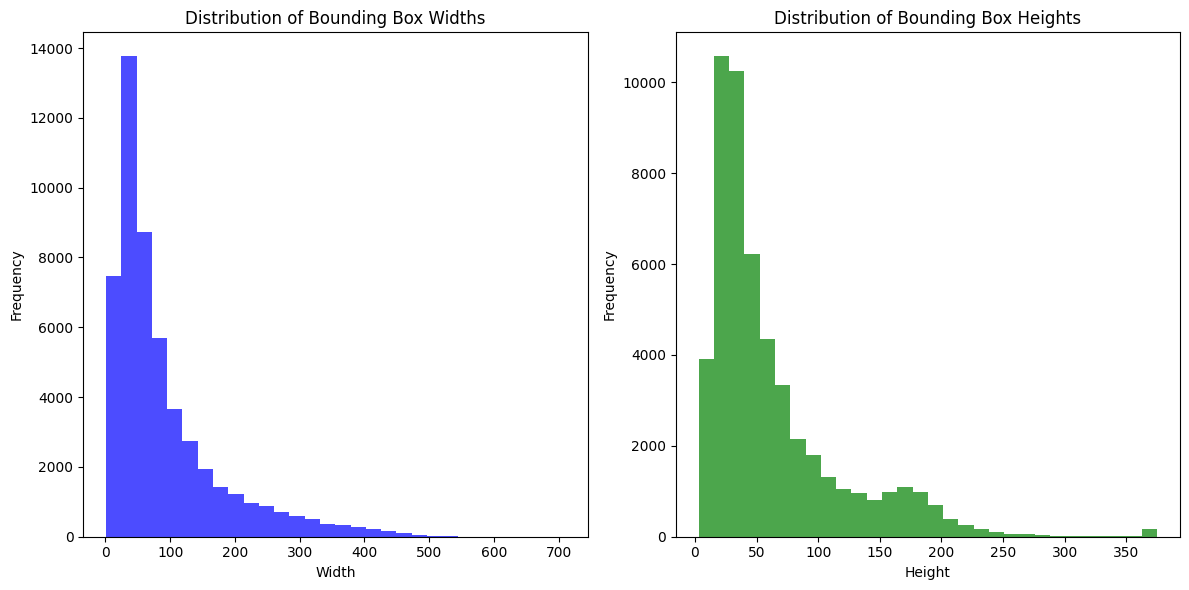

In [22]:
# Extract bounding box coordinates and calculate width and height
df_labels['bbox_width'] = df_labels['bounding_box_coordinates'].apply(lambda x: x[2] - x[0])
df_labels['bbox_height'] = df_labels['bounding_box_coordinates'].apply(lambda x: x[3] - x[1])

# Print basic statistics about bounding box width and height
print("Bounding Box Width Statistics:\n", df_labels['bbox_width'].describe())
print("Bounding Box Height Statistics:\n", df_labels['bbox_height'].describe())

# Plot a histogram of bounding box widths and heights
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df_labels['bbox_width'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Bounding Box Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_labels['bbox_height'], bins=30, color='green', alpha=0.7)
plt.title('Distribution of Bounding Box Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Class Distribution

 **Questions this analysis can help answer:**
 1. **Is there an imbalance in the classes of the target variable?**
    - This can be answered by observing the class distribution and identifying whether certain classes (e.g., cars, pedestrians) are over- or under-represented.
 2. **How is the data distributed based on different categories?**
    - The bar plot provides insights into the frequency of each object class, which can inform model design choices.
 3. **Is there class imbalance?**
    - If class imbalance is identified, you may decide to apply techniques like oversampling, undersampling, or augmentation to balance the dataset.



Class Distribution:
 object_class
Car               28742
DontCare          11295
Pedestrian         4487
Van                2914
Cyclist            1627
Truck              1094
Misc                973
Tram                511
Person_sitting      222
Name: count, dtype: int64


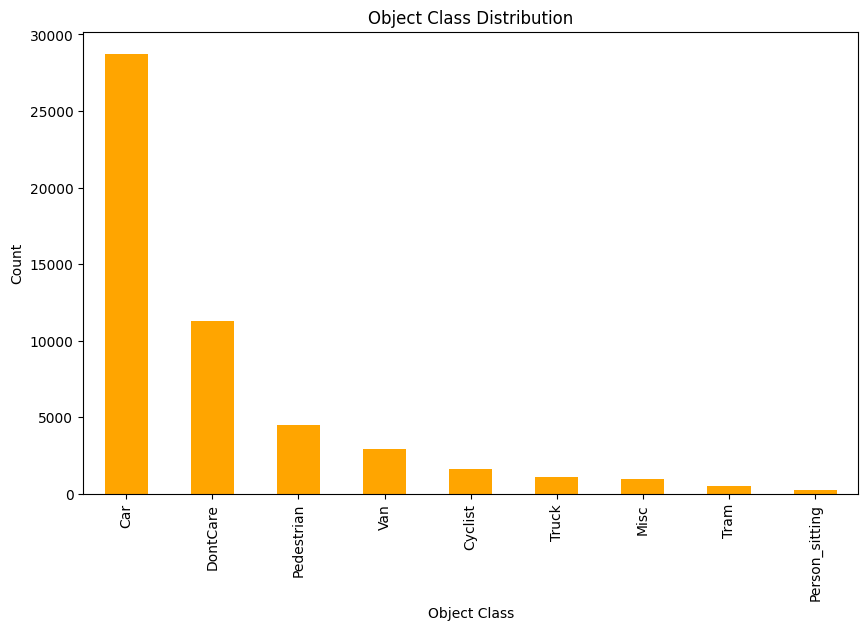

In [23]:
# Get the count of each object class in the labels DataFrame
class_distribution = df_labels['object_class'].value_counts()
print("Class Distribution:\n", class_distribution)

# Plot the class distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar', color='orange')
plt.title('Object Class Distribution')
plt.xlabel('Object Class')
plt.ylabel('Count')
plt.show()

#### Analysis of Calibration Data

In [24]:
# Inspect the first few rows of calibration data for key calibration matrices (e.g., 'P0', 'R0_rect')
calib_matrix_sample = df_calibration['calibration_data'].apply(lambda x: x.get('P0', None)).head()
print("Sample of P0 calibration matrices:\n", calib_matrix_sample)

Sample of P0 calibration matrices:
 0    [707.0493, 0.0, 604.0814, 0.0, 0.0, 707.0493, ...
1    [721.5377, 0.0, 609.5593, 0.0, 0.0, 721.5377, ...
2    [721.5377, 0.0, 609.5593, 0.0, 0.0, 721.5377, ...
3    [721.5377, 0.0, 609.5593, 0.0, 0.0, 721.5377, ...
4    [721.5377, 0.0, 609.5593, 0.0, 0.0, 721.5377, ...
Name: calibration_data, dtype: object


#### Check Object Positioning in Images

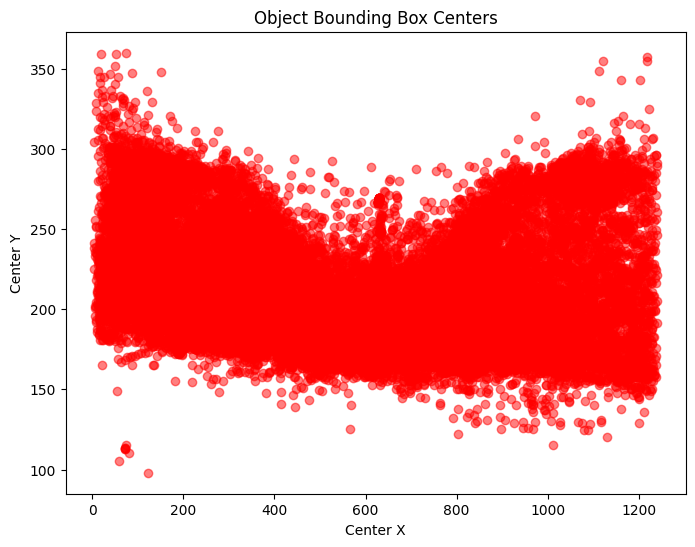

In [25]:
# Calculate the center of each bounding box
df_labels['bbox_center_x'] = df_labels['bounding_box_coordinates'].apply(lambda x: (x[2] + x[0]) / 2)
df_labels['bbox_center_y'] = df_labels['bounding_box_coordinates'].apply(lambda x: (x[3] + x[1]) / 2)

# Plot a scatter plot of object centers
plt.figure(figsize=(8, 6))
plt.scatter(df_labels['bbox_center_x'], df_labels['bbox_center_y'], alpha=0.5, color='red')
plt.title('Object Bounding Box Centers')
plt.xlabel('Center X')
plt.ylabel('Center Y')
plt.show()

#### Outliers for dataset

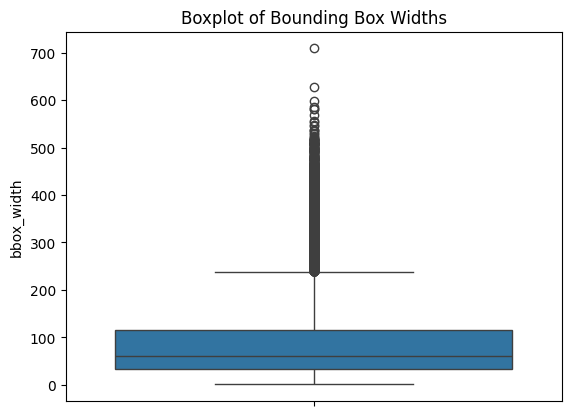

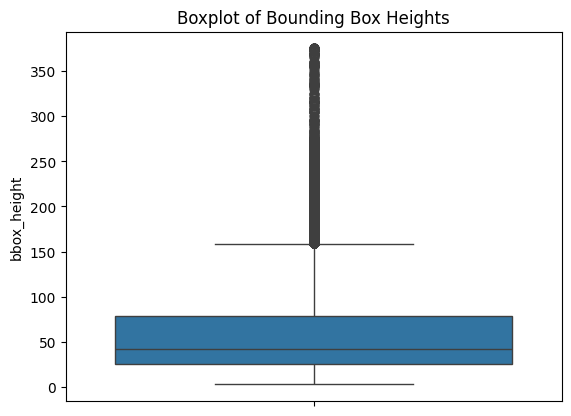

In [27]:
import seaborn as sns

# Boxplot to identify outliers in bounding box widths and heights
sns.boxplot(df_labels['bbox_width'])
plt.title('Boxplot of Bounding Box Widths')
plt.show()

sns.boxplot(df_labels['bbox_height'])
plt.title('Boxplot of Bounding Box Heights')
plt.show()


#### Cardinality of categorical variables

In [28]:
# Check the cardinality of the 'object_class' column
print("Cardinality of object_class:", df_labels['object_class'].nunique())

Cardinality of object_class: 9


#### Skewed distributions in the dataset

In [30]:
from scipy.stats import skew

Skewness of bounding box widths: 1.9004351960212496
Skewness of bounding box heights: 1.944304674930626


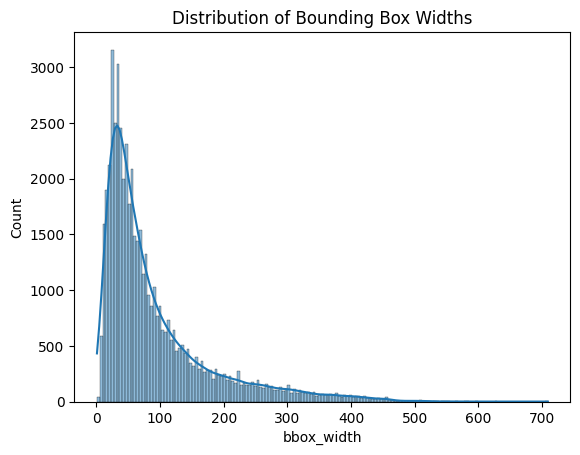

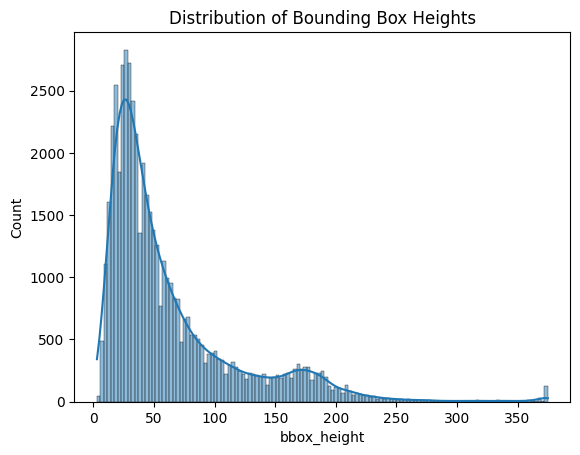

In [31]:
# Calculate skewness of bounding box widths and heights
print("Skewness of bounding box widths:", skew(df_labels['bbox_width']))
print("Skewness of bounding box heights:", skew(df_labels['bbox_height']))

# Plot the distribution to visualize skewness
sns.histplot(df_labels['bbox_width'], kde=True)
plt.title('Distribution of Bounding Box Widths')
plt.show()

sns.histplot(df_labels['bbox_height'], kde=True)
plt.title('Distribution of Bounding Box Heights')
plt.show()

#### Correlation Between Object Class and Bounding Box Size

Average bounding box size by class:
                 bbox_width  bbox_height
object_class                           
Car             111.933373    66.158653
Cyclist          55.840197    76.910879
DontCare         53.355644    25.634883
Misc             90.672148    74.477903
Pedestrian       43.827056   103.753064
Person_sitting   83.684685   102.373874
Tram            153.422701   104.195695
Truck            99.707495    86.394881
Van             109.652025    83.632121


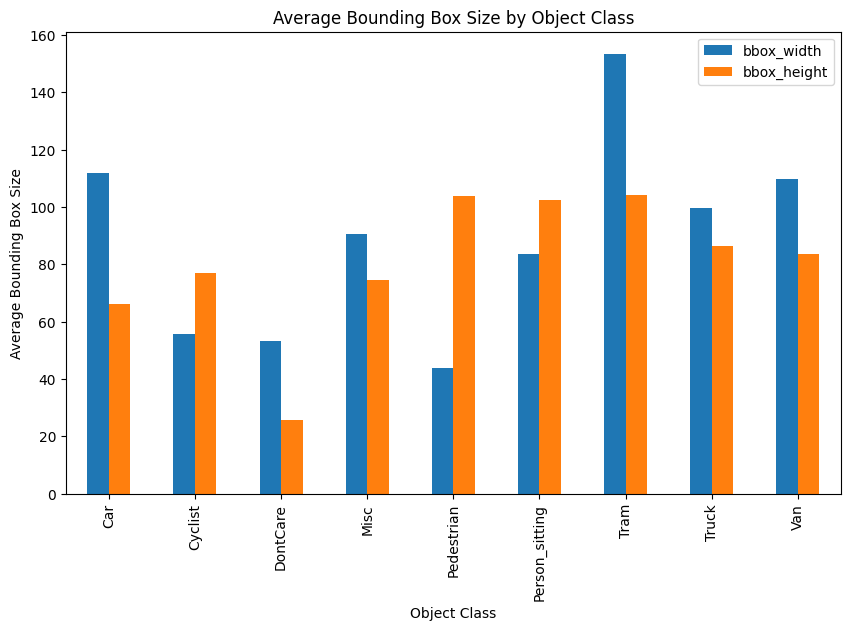

In [33]:
# Calculate the average bounding box width and height for each object class
bbox_stats_by_class = df_labels.groupby('object_class')[['bbox_width', 'bbox_height']].mean()

# Print the average bounding box size for each class
print("Average bounding box size by class:\n", bbox_stats_by_class)

# Plot the average bounding box sizes by class
bbox_stats_by_class.plot(kind='bar', figsize=(10, 6))
plt.title('Average Bounding Box Size by Object Class')
plt.xlabel('Object Class')
plt.ylabel('Average Bounding Box Size')
plt.show()

#### Correlation Between Image Resolution and Bounding Box Size

In [34]:
# Extract image resolution (width and height) using OpenCV
df_images['image_width'] = df_images['file_path'].apply(lambda x: cv2.imread(x).shape[1])
df_images['image_height'] = df_images['file_path'].apply(lambda x: cv2.imread(x).shape[0])

# Merge the image data with the labels data to have bounding box and image resolution together
df_merged = pd.merge(df_labels, df_images, on='image_id')

# Calculate the correlation between image width/height and bounding box size
correlation_width = df_merged[['image_width', 'bbox_width']].corr().iloc[0, 1]
correlation_height = df_merged[['image_height', 'bbox_height']].corr().iloc[0, 1]

print(f"Correlation between image width and bounding box width: {correlation_width}")
print(f"Correlation between image height and bounding box height: {correlation_height}")

Correlation between image width and bounding box width: 0.08773046597852716
Correlation between image height and bounding box height: -0.13039130437293012


#### Correlation Matrix for Numeric Variables

Correlation matrix:
               bbox_width  bbox_height  image_width  image_height
bbox_width      1.000000     0.697399     0.087730      0.088189
bbox_height     0.697399     1.000000    -0.140695     -0.130391
image_width     0.087730    -0.140695     1.000000      0.977786
image_height    0.088189    -0.130391     0.977786      1.000000


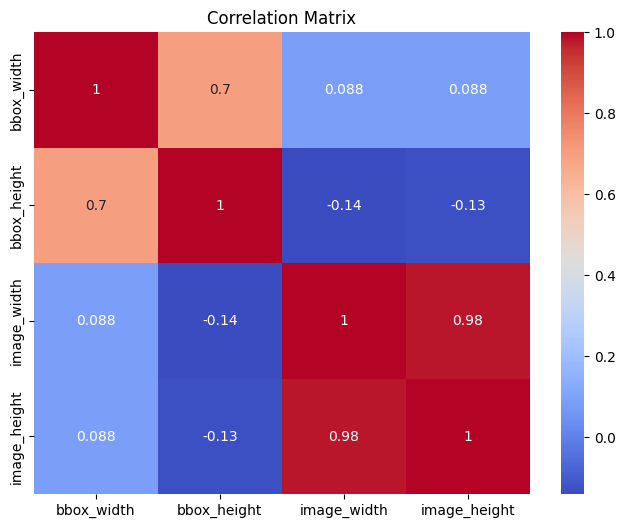

In [35]:
# Correlation matrix for bounding box dimensions and image resolution
correlation_matrix = df_merged[['bbox_width', 'bbox_height', 'image_width', 'image_height']].corr()

print("Correlation matrix:\n", correlation_matrix)

# Visualize the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### Clustering based on bounding box dimensions

In [37]:
from sklearn.cluster import KMeans

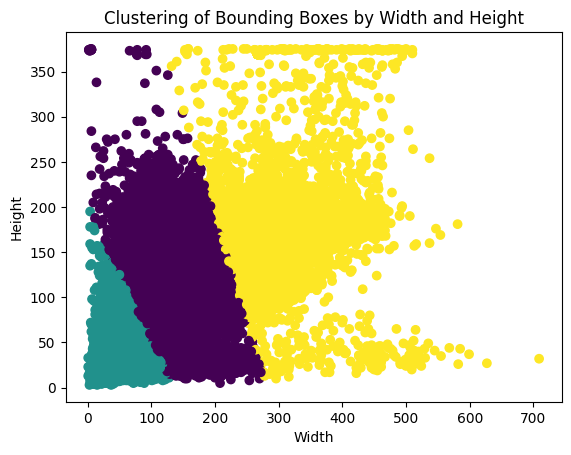

In [38]:
# Perform KMeans clustering based on bounding box dimensions
kmeans = KMeans(n_clusters=3)
df_labels['cluster'] = kmeans.fit_predict(df_labels[['bbox_width', 'bbox_height']])

# Visualize clusters
plt.scatter(df_labels['bbox_width'], df_labels['bbox_height'], c=df_labels['cluster'], cmap='viridis')
plt.title('Clustering of Bounding Boxes by Width and Height')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

#### Normalization or standardization of image pixel values

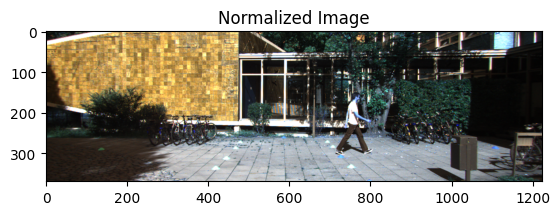

In [39]:
# Example of normalizing an image for visualization
img = cv2.imread(df_images['file_path'][0])
img_normalized = img / 255.0  # Normalize pixel values to the range [0, 1]

plt.imshow(img_normalized)
plt.title('Normalized Image')
plt.show()